# 1. Feature Engineering, Data Cleaning

In [1]:
import re
import pandas as pd
import seaborn as sns

pd.set_option('display.max_colwidth', None)

In [2]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [3]:
# df['spacy_tags'] = df['product_name'].apply(lambda x: [(token.text, token.pos_, token.tag_) for token in nlp(x.lower())])

### Data Summary

In [4]:
df = pd.read_csv('amazon_uk_shoes_products_dataset_2021_12.csv', sep=",")

In [5]:
df.sample(3)[['uniq_id','review_rating', 'scraped_at', 'helpful_count', 'review_title']]

,uniq_id,review_rating,scraped_at,helpful_count,review_title
5129,514f7d95-e2d7-5f30-94f6-8f681c9c5f15,2.0,24/12/2021 02:28:48,35 people found this helpful,I know everyone loves these but.....
5526,5f6ab644-1343-5f34-8ff6-e4844b87198c,5.0,24/12/2021 02:28:56,One person found this helpful,"Got em super cheap, nice basic shoe"
1260,de732f9f-49ab-5392-819d-3c0bddbbb752,2.0,24/12/2021 02:26:57,One person found this helpful,Nope


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6823 entries, 0 to 6822
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   url                6823 non-null   object 
 1   product_name       6823 non-null   object 
 2   reviewer_name      6823 non-null   object 
 3   review_title       6822 non-null   object 
 4   review_text        6814 non-null   object 
 5   review_rating      6823 non-null   float64
 6   verified_purchase  6823 non-null   bool   
 7   review_date        6823 non-null   object 
 8   helpful_count      1953 non-null   object 
 9   uniq_id            6823 non-null   object 
 10  scraped_at         6823 non-null   object 
dtypes: bool(1), float64(1), object(9)
memory usage: 539.8+ KB


In [7]:
df.describe()

,review_rating
count,6823.000000
mean,4.132493
std,1.336969
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [8]:
print("Number of nulls/empty space in each column in the dataframe")
for col in df.columns:
    print(col, " : " , df[col].isna().sum())
    print(col, " : " , (df[col].apply(lambda x: len(str(x))) < 1).sum(), "\n")

Number of nulls/empty space in each column in the dataframe
url  :  0
url  :  0 

product_name  :  0
product_name  :  0 

reviewer_name  :  0
reviewer_name  :  0 

review_title  :  1
review_title  :  0 

review_text  :  9
review_text  :  0 

review_rating  :  0
review_rating  :  0 

verified_purchase  :  0
verified_purchase  :  0 

review_date  :  0
review_date  :  0 

helpful_count  :  4870
helpful_count  :  0 

uniq_id  :  0
uniq_id  :  0 

scraped_at  :  0
scraped_at  :  0 



In [9]:
df[df.duplicated(['uniq_id'], keep=False)].sort_values(['uniq_id'])[['product_name']]

,product_name
5459,konhill Women's Casual Walking Shoes Breathable Mesh Work Slip-on Sneakers 0617 Black Size: 5
3900,"konhill Women's Casual Walking Shoes Breathable Mesh Work Slip-on Sneakers, 0701 All White, 5"
2831,"adidas unisex child Duramo Sl Running Shoe, Black/White/Grey, 1.5 Little Kid US"
2271,adidas Unisex-Child Duramo Sl Running Shoe Size: 4 Toddler
943,"PUMA Women's Ultra TRILLER Cross Trainer, Black-Metallic Gold, 6"
...,...
3077,Merrell Kids&#39; Trail Quest Shoes
2829,"adidas unisex child Duramo Sl Running Shoe, Black/White/Grey, 1.5 Little Kid US"
2269,adidas Unisex-Child Duramo Sl Running Shoe Size: 4 Toddler
5622,"New Balance Men's All Coast 425 V1 Sneaker, Grey/White, 10.5"


In [10]:
df.uniq_id.nunique(), df.shape, df.drop_duplicates().shape

# Implies that there might be duplicate data.
# Reason: the same unique id was used to write the same review + rating for a variation of the same product. 
# i.e. reviews scraped are product (name) variation agnostic

(6641, (6823, 11), (6823, 11))

### Data Cleaning Ideas

1. Extract detailed information from product name -> Shoe company name, Shoe style name, Shoe style design, Shoe Gender.
    - Gender assumption: If neither man/woman/unisex is provided, then child
    - [x] Shoe company name extraction 
    - [x] Shoe style name extraction 
    - [x] Shoe gender name extraction 
2. [x] Extract purchase date from review date
    - [x] Compute difference in days since scrape date
3. [x] Extract purchase market from review date
4. [x] Review language if possible -> extract via langdetect or use market as a proxy for language
5. [x] Check if user name is really a person based on the reviewer name
6. [x] Convert helpful count to float from str
7. [x] See if any columns has missing values. If there are any, how can we fill it? 
8. [x] Assign new unique id per shoe style name to account for 'duplicate data' -> what is the technical name for this sort of data dupe manip if any?
9. [x] Remove Product name [optional] and drop duplicates for all other columns
10. [x] Check data types after extracting possible features
11. [x] Summary of before & after cleaning of data frames
    -  Is the data set balanced for all competitors? If not, what assumption can we make?

#### 1. Extract detailed information from product name

In [11]:
gender_list = ["mens", "womens", "boys", "girls", 'boy', 'girl', "kids", "kid", "men", "women", "child", 'youth', 'yths', 'baby', 'unisex']
brand_list = ["adidas", "puma", "cambridge", "kenneth cole", "new balance", "debaijia", "kappa", "dockers", "geox", "klasified", "rohde", "guess",
             "reebok", "clarks", "skechers", "converse", "merrell", "ara", "mizuno", "superfit", "propet", "konhill", "birkenstock", "crocs",
             "asics", "billabong", "umbro", "levis", "boss", "desconocido", "nike", "hugo", "tiglio", "fischer", "supra", "shimano", "dc",
             "beck", "teva", "keds", "ecco", "ryka", "element", "saucony", "bugatti", "lico", "kangaroos", "nautica", "reef", "bisgaard", 
              "bloch", "blowfish", "brooks", "camper", "columbia", "dearfoams", "demar", "desigual", "diadora", "fila", "florsheim", 
              "gabor", "giesswein", "gioseppo", "hush puppies", "kamik", "keen", "kickers", "kswiss", "laportiva", "lumberjack", "mustang", 
              "naturino", "oshkosh bgosh", "pablosky", "pepe jeans", "pikolinos", "primigi", "richter kinderschuhe", "rockport", "salomon", 
              "sperry", "superga", "timberland", "toddler", "ugg ", "under armour", "victoria"]

In [12]:
brand_dict = dict()
style_dict = dict()
gender_dict = dict()

In [13]:
def preprocess_product_name(text: str):
    text = re.sub("&#39;", "'", text)
    text = re.sub("’", "'", text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub("é", "e", text)
    return text.lower().strip()

def reduce_brand_name(text: str):
    output = text.strip()
    for gender in gender_list:
        if gender in text:
            output = text.replace(gender, "").strip()
        else:
            pass
    output = output.replace(" s", "")
    
    for brand in brand_list:
        if brand in output:
            output = brand
        else:
            pass
    return output

def compound_gender(g_list: list):
    output = g_list[0]
    if len(g_list) > 1:
        output = 'unisex'
    else:
        output = g_list[0]
    return output

def style_extractor(text: str):
    
    '''
    regex to replace digits, eu, us, uk, size, color, colour with null space
    '''
    
    text = re.sub("\d+", "", text)
    text = re.sub("eu|uk|us|size|color|colour", '', text)
    text = re.sub("  ", " ", text)
    text = text.strip()
    
    words = text.split()
    text = " ".join(sorted(set(words), key=words.index))
    return text

    

In [14]:
df['product_name'] = df['product_name'].map(preprocess_product_name)
all_products = df['product_name'].drop_duplicates().apply(lambda x: x.split(" ")).tolist()

In [15]:
for prd in all_products:
    for gender in gender_list:
        try:
            gender_set = set()
            results = re.findall(r'((?:fe)?male)|((?:wo)?men)|(unisex)', " ".join(prd))
            for item in results:
                for i in item:
                    gender_set.add(i)
            gender_set.remove('')
            gender_dict[" ".join(prd)] = list(gender_set)
            
            if gender == prd[1]:
                brand_dict[" ".join(prd)] = " ".join(prd[:1])
                style_dict[" ".join(prd)] = " ".join(prd[2:])
            elif gender == prd[2]:
                brand_dict[" ".join(prd)] = " ".join(prd[:2])
                style_dict[" ".join(prd)] = " ".join(prd[3:])
            elif (gender != prd[1]) & (gender != prd[2]) & (gender != prd[3]) & (gender != prd[0]):
                brand_dict[" ".join(prd)] = " ".join(prd[:2])
                style_dict[" ".join(prd)] = " ".join(prd[3:])
                
        except:
            brand_dict[" ".join(prd)] = " ".join(prd)
            style_dict[" ".join(prd)] = " ".join(prd[2:])
            gender_dict[" ".join(prd)] = ["child"]

In [16]:
df["product_brand_name"] = df["product_name"].map(brand_dict)
df["product_brand_name"] = df["product_brand_name"].map(reduce_brand_name)

In [17]:
df["product_style_name"] = df["product_name"].map(style_dict)
df.loc[df.product_style_name=='', "product_style_name"] = df.loc[df.product_style_name=='', "product_brand_name"]
df["product_style_name"] = df["product_style_name"].map(style_extractor)

In [18]:
df["product_shoe_gender"] = df["product_name"].map(gender_dict)
df['product_shoe_gender'] = df['product_shoe_gender'].map(compound_gender)

#### 2,3. Extract information from review date data

In [19]:
from spacy.matcher import Matcher

matcher = Matcher(nlp.vocab)
pattern1 = [{"POS": "NUM"}, {"POS": "PROPN"}, {"POS": "NUM"}]
pattern2 = [{"POS": "PROPN"}]
matcher.add("PROPER_NOUNS", [pattern1, pattern2], greedy='LONGEST')


def market_date_matcher(text: str):
    
    output = dict()
    loc = ''
    
    doc = nlp(text)
    matches = matcher(doc)
    
    date = doc[matches[0][1]:matches[0][2]]
    for match in matches[1:]:
        loc =  loc + str(doc[match[1]:match[2]]) + ' '
    output["market"] = loc.strip()
    output["date"] = str(date)
    
    return output

In [20]:
%%time
df['review_market'] = df['review_date'].apply(lambda x: market_date_matcher(x)['market'])
df['review_posted_date'] = df['review_date'].apply(lambda x: market_date_matcher(x)['date'])

CPU times: user 30.2 s, sys: 124 ms, total: 30.3 s
Wall time: 30.5 s


In [21]:
df['scraped_at'] = pd.DatetimeIndex(df['scraped_at'])
df['review_posted_date'] = pd.DatetimeIndex(df['review_posted_date'])

In [22]:
df['scraped_date_diff_posted'] = (df['scraped_at'] - df['review_posted_date']).dt.days

#### 4. Review Language assigning

Fill missing review text (nans) with copy of review title.

In [23]:
import langdetect
from langdetect import detect 
langdetect.DetectorFactory.seed = 0

In [24]:
df.loc[df.review_text.isna(), "review_text"] = df.loc[df.review_text.isna(), "review_title"]

<Axes: ylabel='Frequency'>

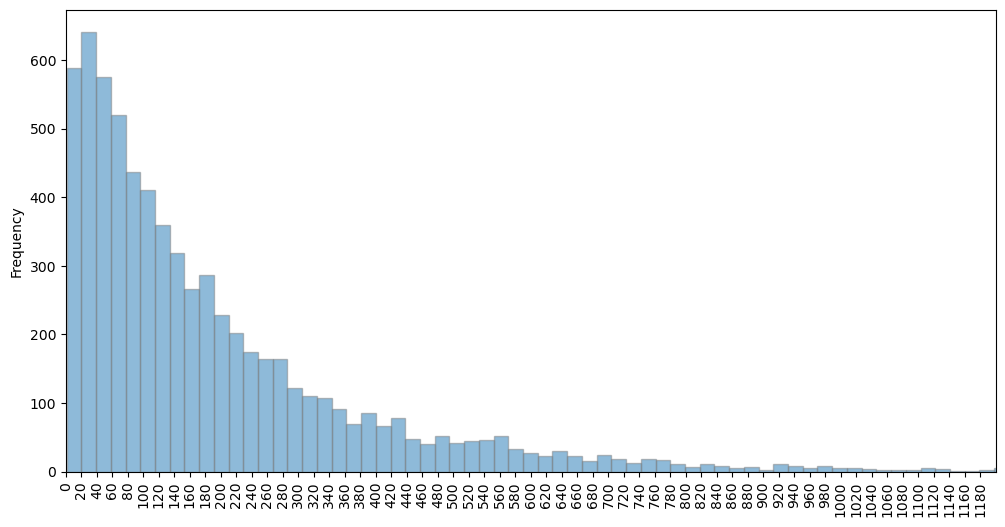

In [25]:
df.review_text.map(len).plot.hist(bins=200, alpha=0.5, xlim=(0,1200), 
                                  xticks=list(range(0, 1200, 20)), rot=90, 
                                  figsize=(12,6),  edgecolor = "grey")

In [26]:
%%time
# cut off of applying langdetect package to only reviews that have more than 20 characters as per the review length distribution above
# discard using the langdetect package on reviews less than 20 chars as the package works best on long text
df['review_lang'] = df['review_text'].apply(lambda x:  detect(x) if len(x) > 20 else 'nan')

CPU times: user 7.15 s, sys: 53 ms, total: 7.2 s
Wall time: 6.87 s


#### 5. Check if user name is really a person based on the reviewer name


In [27]:
from collections import Counter

In [28]:
def real_username(user_name: str):
    default = 'Processed Amazon Customer'
    pos_tag_counter = Counter([(token.pos_) for token in nlp(user_name.strip())])
    if ((len(pos_tag_counter) < 3) & ('PROPN' in pos_tag_counter)) | ((len(pos_tag_counter) < 2) & ('NOUN' in pos_tag_counter)):
        default = user_name
    else:
        pass 
    return default

In [29]:
%%time
df['checked_user_name'] = df['reviewer_name'].apply(lambda x: real_username(x))

CPU times: user 11.1 s, sys: 37.4 ms, total: 11.1 s
Wall time: 11.1 s


#### 6,7. Convert helpful count from str to float. Deal with missing values

In [30]:
df.loc[df.review_title.isna(), "review_title"] = " "

In [31]:
df['helpful_count'] = df['helpful_count'].fillna('0')
df['helpful_count_int'] = df['helpful_count'].apply(lambda x: 1 if x.split(" ")[0] == 'One' else int(x.split(" ")[0]))

In [32]:
print("Number of nulls/empty space in each column in the dataframe")
for col in df.columns:
    print(col, " : " , df[col].isna().sum())
    print(col, " : " , (df[col].apply(lambda x: len(str(x))) < 1).sum(), "\n")

Number of nulls/empty space in each column in the dataframe
url  :  0
url  :  0 

product_name  :  0
product_name  :  0 

reviewer_name  :  0
reviewer_name  :  0 

review_title  :  0
review_title  :  0 

review_text  :  0
review_text  :  0 

review_rating  :  0
review_rating  :  0 

verified_purchase  :  0
verified_purchase  :  0 

review_date  :  0
review_date  :  0 

helpful_count  :  0
helpful_count  :  0 

uniq_id  :  0
uniq_id  :  0 

scraped_at  :  0
scraped_at  :  0 

product_brand_name  :  0
product_brand_name  :  0 

product_style_name  :  0
product_style_name  :  20 

product_shoe_gender  :  0
product_shoe_gender  :  0 

review_market  :  0
review_market  :  0 

review_posted_date  :  0
review_posted_date  :  0 

scraped_date_diff_posted  :  0
scraped_date_diff_posted  :  0 

review_lang  :  0
review_lang  :  0 

checked_user_name  :  0
checked_user_name  :  0 

helpful_count_int  :  0
helpful_count_int  :  0 



#### 8,9. Dealing with duplicate data

In [33]:
df_uniq = df.drop_duplicates(['uniq_id', 'product_name', 'review_text'])

In [34]:
df.shape, df_uniq.shape

((6823, 20), (6820, 20))

#### 10. Data Types checking

In [35]:
df_uniq = df_uniq[['uniq_id', 'product_brand_name', 'product_style_name', 'product_shoe_gender', 'product_name',  
'checked_user_name', 'verified_purchase',  'review_title', 'review_text', 'review_rating', 'review_market', 
'review_posted_date', 'review_lang',  'helpful_count_int', 'scraped_date_diff_posted', 'reviewer_name', 
'review_date',  'scraped_at', 'helpful_count', 'url']].sort_values(['uniq_id']).reset_index(drop=True)

In [36]:
df_uniq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6820 entries, 0 to 6819
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   uniq_id                   6820 non-null   object        
 1   product_brand_name        6820 non-null   object        
 2   product_style_name        6820 non-null   object        
 3   product_shoe_gender       6820 non-null   object        
 4   product_name              6820 non-null   object        
 5   checked_user_name         6820 non-null   object        
 6   verified_purchase         6820 non-null   bool          
 7   review_title              6820 non-null   object        
 8   review_text               6820 non-null   object        
 9   review_rating             6820 non-null   float64       
 10  review_market             6820 non-null   object        
 11  review_posted_date        6820 non-null   datetime64[ns]
 12  review_lang         

In [37]:
df_uniq.describe()

,review_rating,helpful_count_int,scraped_date_diff_posted
count,6820.000000,6820.000000,6820.000000
mean,4.132111,1.269208,538.662610
std,1.337139,5.497773,493.626145
min,1.000000,0.000000,4.000000
25%,4.000000,0.000000,192.000000
50%,5.000000,0.000000,399.000000
75%,5.000000,1.000000,759.250000
max,5.000000,165.000000,4264.000000


Implications from above summary table for the 3 data points:
1. The std of `review_rating` is 1.33 AND the values at 25%ile onwards are 4+. This means that atleast 75% of the reviews in this dataset have > 4 rating. Using review rating alone as a metric for popularity in this case will not be enough to understand the bigger picture. So we need to combine this with other metrics to understand popularity.

2. For `helpful_count_int`, only very few reviews have been helpful to others from our data. 

3. From `scraped_date_diff_posted`, we see that the num of recent reviews has been very less compared to old reviews. This could be because the reviews for the products we're extracting are all old products/brands and consumers now might be buying other new products which we haven't scraped yet. Or it could also be that shoes are the kind of product that you leave a review if it is either really good or bad. 

In [39]:
df_uniq.to_csv("cleaned_df.csv", sep="\t", index=False)

### Next notebook 

02_tasks.ipynb contains solution and thought process to tackling the different tasks outlined in the challenge